# RL from Scratch (with less crying)

What's up everybody. My post on [Llama from scratch]() got a decent bit of attention (pun intended), so I've decided to keep going and try a field of ML which is becoming increasingly important: reinforcement learning. 

Over the next few series of posts, we're going to try to work our way up to the landmark AI projects from the last few years, from scratch, with the mistakes you might see while implementing, and able to be run locally. They're going to be intuitive, digestible, and hopefully helpful for both makers making, as well as for people who are just entertained by this stuff. Think 3Blue1Brown, but for ML. 

## 1. The mental switch from vanilla ML to RL

Gonna be honest with y'all, there was definitely a psychological hurdle for me going from the mental frameworks used for vanilla ML to reinforcement learning. When I say vanilla ML here, I mean the kinds of projects where you're given a dataset (MNIST, Titanic, even TinyShakespeare) and asked to learn classifiers/regressors/predictors. And I also pretty much just mean neural nets (no EM stuff, although now that I think about it there's probably a neat linkage between EM and actor-critic, but I digress).

My mental framework for vanilla ML:
1. Get a dataset
1. Map a single example to its label
1. Define a loss function
1. Figure out how to train it in batches
1. Profit.

And I've made a lot of assumptions, namely:
- with a big enough dataset and well-parametrized model, it will *just work*
- training in batches can *happen*
- I can *watch* the model's performance improve

Ilya Sutskever just gave a great talk on why supervised learning "makes sense": given a class of functions and a dataset, we can prove claims about our ability to learn, via the generalization lower bound. So we feel pretty confident going in that with a beefy enough neural net, we'll get a small enough error to make ourselves feel good.

### Why do I (brian) even care?
RL is what has succeeded in tasks like games (backgammon, chess, go, Atari), and is also used for things like stock trading. It's also, crazily enough, what OpenAI chose to train ChatGPT, which it based off of InstructGPT, which it based off of *both* GPT-3 *and* [training an agent to do a backflip](https://openai.com/research/learning-from-human-preferences). 

To me, that thread is as elegant as some of the landmark achievements in math (Godel's Incompleteness Theorem, the Spectral Theorem, among others), and I want to piece together that art for others.

### Why are we using the word *agent* at all?
Well, that's probably one of the things that makes RL harder the vanilla ML: vanilla ML has basically no interactivity with its training environment. The dataset is made and frozen, and the model relies on the unchanging dataset to learn. In fact, concept drift or distribution drift, a notorious problem for deploying ML models where model performance continously degrades over time, happens because we train our vanilla ML models on unchanging data.

### okay, back to the fear
So what makes RL scary to me? Well for one thing, *there's not always a dataset*. That's like table stakes. How are you supposed to learn without data. Bonkers. There goes framework principle number one.

1. ~~Get a dataset~~
1. Map a single example to its label
1. Define a loss function
1. Figure out how to train it in batches
1. Profit.

Instead, we have to generate a dataset, which we do by 

Now the next leap is mapping an example to a label. And that's like, explicitly not what we do with RL. With RL, we don't even have samples to map to, because we don't have a dataset, and we don't have labels, because again we don't have a dataset. We have to generate it all by running simulations of our model in an environment, which we call *episodes*. 

In [2]:
import gymnasium as gym
import numpy as np
gym.__version__

'0.29.0'

# Understanding the environment

In [3]:
env = gym.make("LunarLander-v2")

From [docs](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

## Action Space
There are four discrete actions available:

0: do nothing

1: fire left orientation engine

2: fire main engine

3: fire right orientation engine


In [4]:
env.action_space

Discrete(4)


## Observation Space
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.


In [5]:
print(env.observation_space.shape)
env.observation_space

(8,)


Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

For a single layer policy network, we can interpret the layer weights as the following matrix: 

|                      | x-coord | y-coord | x-vel | y-vel | angle | angular-vel | left-leg-contact | right-leg-contact |
|----------------------|---------|---------|-------|-------|-------|-------------|------------------|-------------------|
| action 0: no-op      |         |         |       |       |       |             |                  |                   |
| action 1: fire left  |         |         |       |       |       |             |                  |                   |
| action 2: fire main  |         |         |       |       |       |             |                  |                   |
| action 3: fire right |         |         |       |       |       |             |                  |                   |


Some scenarios we might see in our environment:
- if in the given episode it never made contact (the lander spun upside-down), then the policy gradient would be 0 for the left/right leg contact.

## Rewards
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
An episode is considered a solution if it scores at least 200 points.

## Taking a step

In [1]:
env.reset()
observation, reward, terminated, truncated, info = env.step(0)
reward

NameError: name 'env' is not defined

## Reinforcement Learning Objective

Our performance measure: 

$$
J(\theta) = \mathbb{E} \left[ \sum_{t=0}^{T-1}r_{t+1} \right]
$$

and our update rule:

$$
\theta \leftarrow \theta + \frac{\partial}{\partial \theta} J(\theta)
$$

The gradient
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ \sum_a q_\pi(S_t, a) \nabla \pi (a | S_t, \theta) \right]
$$
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ \sum_a \pi (a | S_t, \theta) q_\pi(S_t, a) \frac{\nabla \pi (a | S_t, \theta)}{\pi (a | S_t, \theta)} \right]
$$

If we sample $A_t \sim \pi$, then we just replace the expectation over $a$ with the sample $A_t$. So we're doing this swap from expectation to sample:
$$
\sum_a \pi (a | S_t, \theta) q_\pi(S_t, a) \rightarrow q_\pi(S_t, A_t)
$$
which then simplifies $\nabla J(\theta)$ to

$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ q_\pi(S_t, A_t) \frac{\nabla \pi (A_t | S_t, \theta)}{\pi (A_t | S_t, \theta)} \right]
$$

and by $\mathbb{E}_\pi [G_t | S_t, A_t] = q_\pi (S_t, A_t)$, (add note to explain how we get G_t)

$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ G_t \frac{\nabla \pi (A_t | S_t, \theta)}{\pi (A_t | S_t, \theta)} \right]
$$

We're going to make one more simplification: note that $\nabla \ln x = \frac{\nabla x}{x}$, so
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ G_t \nabla \ln \pi (A_t | S_t, \theta) \right]
$$

Now, we can actually calculate the value in brackets at each time step, and can then use it to update $\theta$:

$$
\theta_{t+1} = \theta_t + \alpha G_t \nabla \ln \pi(A_t | S_t, \theta_t)
$$

We're now going to generate an episode $S_0, A_0, R_1,...,S_{T-1}, A_{T-1}, R_T$.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize policy network
# takes in a state, determines the next action
class PolicyNetwork(nn.Module):
    def __init__(self, obs_size, action_size):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(obs_size, action_size, bias=False),
            nn.ReLU()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        logits = self.layer(x)
        return torch.log(F.softmax(logits, dim=-1) + 1e-9)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        log_probs = self.forward(state).squeeze(0)
        probs = torch.exp(log_probs)
        action = torch.multinomial(probs, 1)
        return action.item(), log_probs[action]
    
model = PolicyNetwork(env.observation_space.shape[0], (env.action_space.n - env.action_space.start))

Here is a full episode of the moon landing.

In [8]:
def run_episode(model, env=env):
    observation, _ = env.reset()

    rewards = []
    log_probs = []
    actions = []
    observations = []

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)

        actions.append(action)
        rewards.append(reward)
        log_probs.append(_log_probs)
        observations.append(observation)

        if terminated:
            break

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs, actions, np.array(observations)

model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
rewards, log_probs, actions, observations = run_episode(model)

# print(rewards.shape)
# print(len(log_probs))
# print(actions)
# print(observations)

del model, rewards, log_probs, actions, observations

Notice how `log_probs` is an array of `torch.tensor`. We need this to be the case, because we have to run `.backward` on it later to calculate the gradients. Without doing this, we can't really use pytorch to do the heavy lifting for us.

Now, at the end of the episode, we need to determine $G$, the expected reward at each timestep.

In [9]:
def discount_rewards(rewards, gamma=.99):
    G = []
    R = 0
    for i in reversed(range(len(rewards))):
        R = rewards[i] + gamma * R
        G.insert(0, R)
    return G

# test it
r = np.array([1,1,1,1,1])
g = np.array(discount_rewards(r))
t = np.array([4.90099501, 3.940399, 2.9701, 1.99, 1])
assert np.allclose(g, t), "Incorrect sum of discounted rewards"
del r, g, t

In [10]:
def update(model, log_probs, rewards, alpha=0.01, gamma=0.99):
    # compute the discounted rewards
    G = discount_rewards(rewards, gamma)
    for t in range(len(G)):
        log_prob = log_probs[t]
        g = G[t]

        model.optimizer.zero_grad() # reset the gradients
        log_prob.backward() # compute the gradients of log pi(A_t, S_t, theta) at each timestep
        for param in model.parameters():
            if param.grad is not None:
                param.grad = alpha * gamma**t * g * param.grad # scale the gradients by the reward
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        model.optimizer.step() # update the weights using the gradients

# testing the update function
model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)

rewards, log_probs, actions, observations = run_episode(model)

old = list(model.parameters())[0].clone()
update(model, log_probs, rewards, alpha=1., gamma=1.) # no discounting, no scaling
new = list(model.parameters())[0].clone()

delta = new - old
print(delta)

left_leg_contact = (observations[:, -2]).sum() > 0
right_leg_contact = (observations[:, -1]).sum() > 0

left_leg_delta = delta[:, -2].sum(axis=0)
right_leg_delta = delta[:, -1].sum(axis=0)

# if there was no right leg contact, the right leg should have 0 delta
assert left_leg_contact == True or left_leg_delta == 0.
assert right_leg_contact == True or right_leg_delta == 0.

# del model, rewards, log_probs

tensor([[-0.0101,  0.0040, -0.0052, -0.0080,  0.0083, -0.0001,  0.0000,  0.0000],
        [ 0.0126, -0.0039,  0.0085,  0.0115, -0.0105,  0.0003,  0.0000, -0.0008],
        [-0.0300,  0.0162, -0.0211, -0.0260,  0.0279,  0.0166,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       grad_fn=<SubBackward0>)


And now we'll try it for a bunch of episodes.

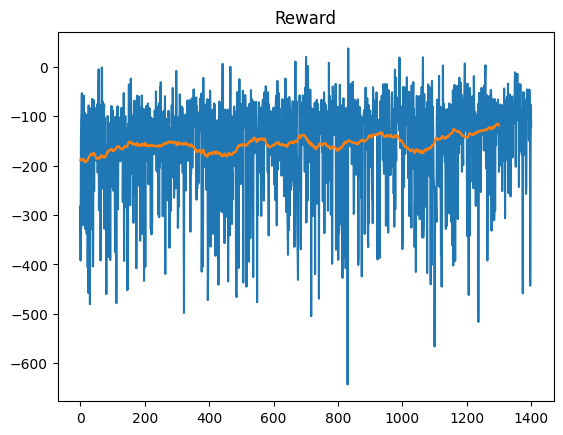

In [11]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(1500):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

So at some point in training, we run an episode which totally goes off the rails, yielding a reward that is many standard deviations from the normal range. I think the sessions are also probably longer too, because the lunar lander is just wizzing around, yielding bad rewards and many timesteps. We can check this easily by plotting the number of steps in an episode.

In [13]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i in range(1500):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

KeyboardInterrupt: 

Yep, so we need to cap our episode lengths. If we don't solve within say 1000 steps, it should just be a failure.

In [14]:
def run_episode(model, env=env, max_steps=1000):
    observation, _ = env.reset()

    rewards = []
    log_probs = []
    actions = []
    observations = []

    steps = 0

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        steps += 1

        actions.append(action)
        rewards.append(reward)
        log_probs.append(_log_probs)
        observations.append(observation)

        if terminated:
            break

        if steps >= max_steps:
            break

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs, actions, np.array(observations)

model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
rewards, log_probs, actions, observations = run_episode(model)

# print(rewards.shape)
# print(len(log_probs))
# print(actions)
# print(observations)

del model, rewards, log_probs, actions, observations

In [15]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i in range(5000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

KeyboardInterrupt: 

Interesting: the policy that we're learning is now just learning to fly off without landing. The behavior we're learning is to not actually land, but to not crash. Note how the score is never breaking above 100, so it's likely never learning to land. We can check this as well by plotting the moving average of how many episodes end with both legs in contact.

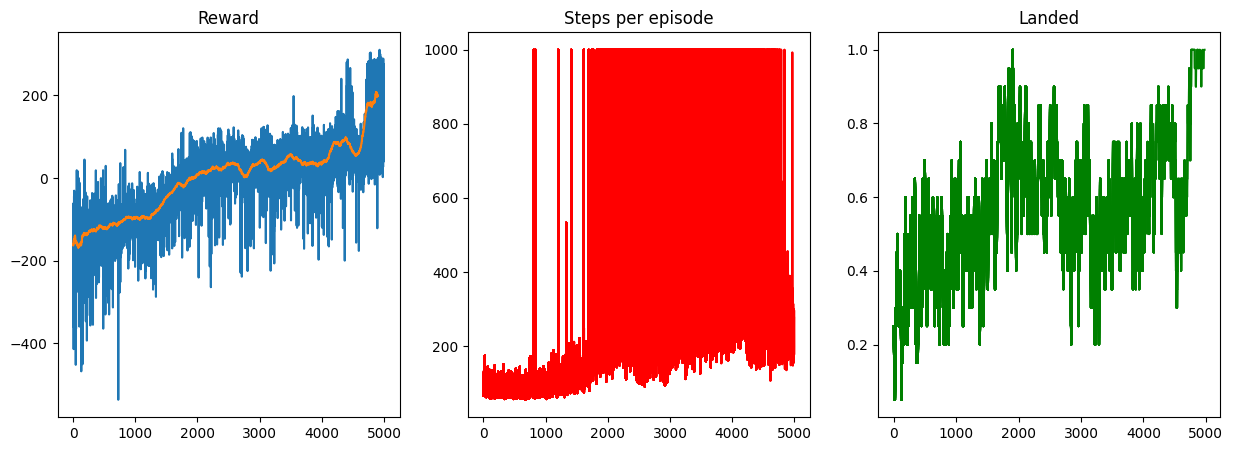

In [16]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
landed = []

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

for i in range(5000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]
    landed += [observations[-1, -2:].sum() == 2]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')
        ax2.set_title("Steps per episode")

        # and the number of times we landed
        ax3.set_title("Landed")
        if len(landed) > 20:
            smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
            ax3.plot(smoothed, color='green')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

ax.clear()
ax.plot(rewards_track)
ax.set_title("Reward")

# add a smoothed version
if len(rewards_track) > 100:
    smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
    ax.plot(smoothed)

# also plot the number of steps
ax2.plot(steps_per_episode, color='red')
ax2.set_title("Steps per episode")

# and the number of times we landed
ax3.set_title("Landed")
if len(landed) > 20:
    smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
    ax3.plot(smoothed, color='green')

display(fig)

Okay, so it is working now! I speculate that if we add a large negative reward if we don't land in time, then we'll also train faster.

In [17]:
def run_episode(model, env=env, max_steps=1000, overstep_penalty=-100):
    observation, _ = env.reset()

    rewards = []
    log_probs = []
    actions = []
    observations = []

    steps = 0

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        steps += 1

        actions.append(action)
        rewards.append(reward)
        log_probs.append(_log_probs)
        observations.append(observation)

        if terminated:
            break

        if steps >= max_steps:
            rewards[-1] += overstep_penalty
            break

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs, actions, np.array(observations)

model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
rewards, log_probs, actions, observations = run_episode(model)

# print(rewards.shape)
# print(len(log_probs))
# print(actions)
# print(observations)

del model, rewards, log_probs, actions, observations

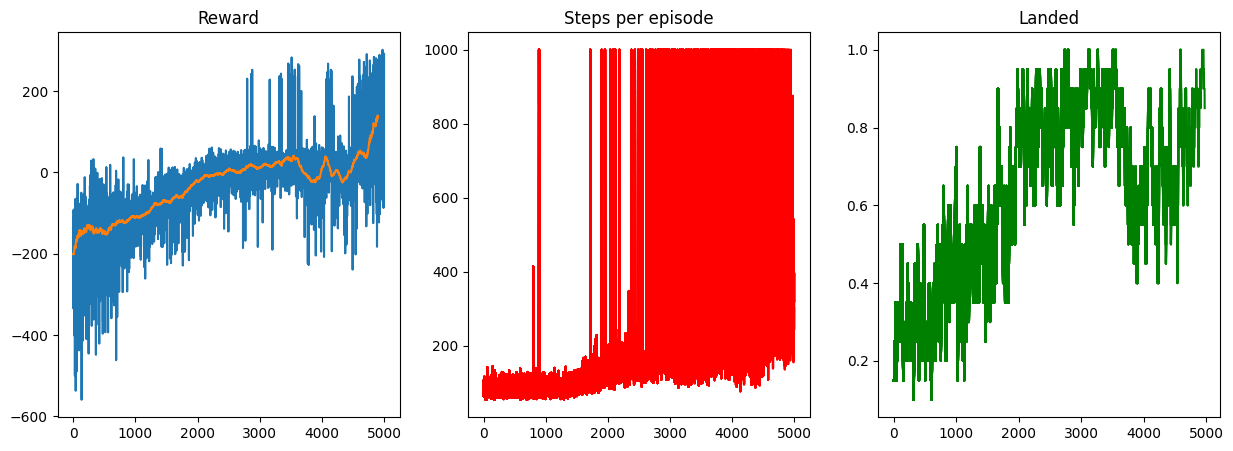

In [21]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
landed = []

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

for i in range(5000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]
    landed += [observations[-1, -2:].sum() == 2]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')
        ax2.set_title("Steps per episode")

        # and the number of times we landed
        ax3.set_title("Landed")
        if len(landed) > 20:
            smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
            ax3.plot(smoothed, color='green')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

ax.clear()
ax.plot(rewards_track)
ax.set_title("Reward")

# add a smoothed version
if len(rewards_track) > 100:
    smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
    ax.plot(smoothed)

# also plot the number of steps
ax2.plot(steps_per_episode, color='red')
ax2.set_title("Steps per episode")

# and the number of times we landed
ax3.set_title("Landed")
if len(landed) > 20:
    smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
    ax3.plot(smoothed, color='green')

display(fig)

Now let's try a larger network, with more than one hidden layer.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize policy network
# takes in a state, determines the next action
class BeefyPolicyNetwork(nn.Module):
    def __init__(self, obs_size, action_size, hidden_size=128):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(obs_size, hidden_size, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size, bias=False),
            nn.ReLU()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        logits = self.layer(x)
        return torch.log(F.softmax(logits, dim=-1) + 1e-9)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        log_probs = self.forward(state).squeeze(0)
        probs = torch.exp(log_probs)
        action = torch.multinomial(probs, 1)
        return action.item(), log_probs[action]
    
model = BeefyPolicyNetwork(env.observation_space.shape[0], (env.action_space.n - env.action_space.start))
model.act(np.random.randn(8))[1].backward()
list(model.parameters())[0].grad

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.5863e-03,  5.1790e-03, -2.9792e-04,  ..., -9.6691e-05,
          8.9327e-03,  5.1622e-03],
        [-2.5627e-03, -2.0151e-03,  1.1592e-04,  ...,  3.7621e-05,
         -3.4756e-03, -2.0086e-03],
        ...,
        [-2.7561e-02, -2.1672e-02,  1.2467e-03,  ...,  4.0461e-04,
         -3.7380e-02, -2.1602e-02],
        [-4.3869e-03, -3.4495e-03,  1.9843e-04,  ...,  6.4401e-05,
         -5.9496e-03, -3.4383e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [128, 4]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

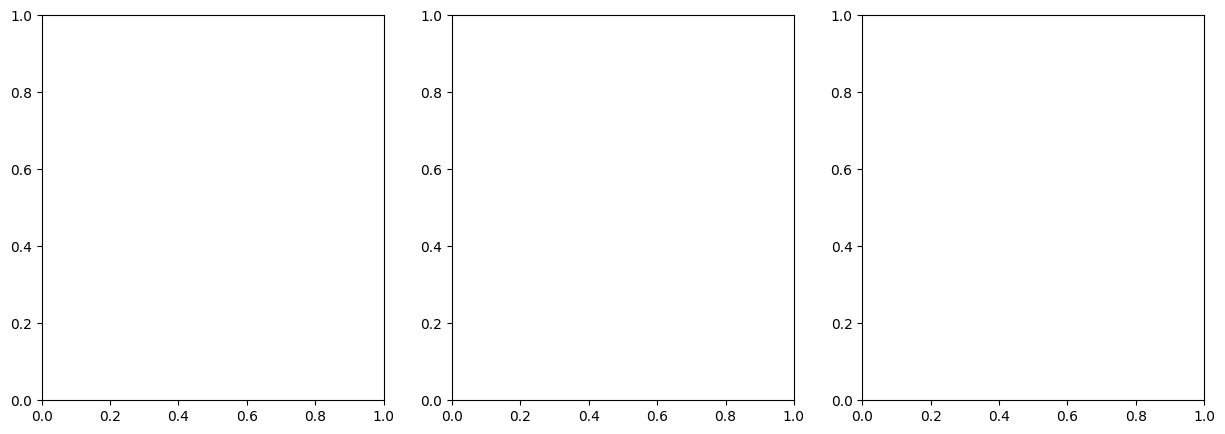

In [19]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = BeefyPolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
landed = []

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

for i in range(5000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]
    landed += [observations[-1, -2:].sum() == 2]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')
        ax2.set_title("Steps per episode")

        # and the number of times we landed
        ax3.set_title("Landed")
        if len(landed) > 30:
            smoothed = [np.mean(landed[i:i+30]) for i in range(len(landed) - 30)]
            ax3.plot(smoothed, color='green')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

Oh man, so getting a deeper policy network to back propagate is going to be not as straightforward. We'll work on this in the next post.